<a href="https://colab.research.google.com/github/NilakshanRaveendran/TransformerModel/blob/main/TransformerModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Obtaing data

In [ ]:
import tensorflow as tf
import os
import zipfile

# Step 1: Download zip
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="https://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip"
)

# Step 2: Extract manually (since extract=True didn’t work)
extract_dir = os.path.dirname(text_file)
with zipfile.ZipFile(text_file, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

# Step 3: Verify the text file path
text_file = os.path.join(extract_dir, "fra.txt")
print("Extracted to:", text_file)

# Step 4: Read the text
with open(text_file) as fp:
    text_pair = [line for line in fp]


Extracted to: /root/.keras/datasets/fra.txt


In [ ]:
import random

for i in range(5):
  print(random.choice(text_pair))

Tom is falling asleep.	Tom tombe de sommeil.

Tom doesn't seem to be very intelligent.	Tom ne semble pas très intelligent.

That looks like blood.	On dirait du sang.

I can't give up.	Je n'arrive pas à arrêter.

You're half right.	Vous avez à moitié raison.



In [ ]:
import unicodedata
import re

def normalize(line):
    line = unicodedata.normalize("NFKC", line.strip().lower())

    # Skip invalid or empty lines
    if "\t" not in line:
        return None

    eng, fre = line.split("\t", 1)  # split only once
    fre = "[start] " + fre.strip() + " [end]"
    return eng.strip(), fre

In [ ]:
with open(text_file) as fp:
    text_pair = [normalize(line) for line in fp]

In [ ]:
for i in range(5):
  print(random.choice(text_pair))

("i'm the only one you can trust.", '[start] je suis la seule à qui vous pouvez faire confiance. [end]')
('a traffic accident deprived him of the use of his left hand.', '[start] un accident de la route l’a privé de l’utilisation de sa main gauche. [end]')
('there are a couple of options.', '[start] il y a quelques options. [end]')
('he abandoned the idea.', "[start] il a abandonné l'idée. [end]")
('read as many books as possible.', '[start] lis le plus de livres possible. [end]')


In [ ]:
eng_tokens, fre_tokens = set(), set()
eng_maxlen, fre_maxlen = 0, 0

for eng, fre in text_pair:
  eng_token, fre_token = eng.split(), fre.split()
  eng_maxlen = max(eng_maxlen, len(eng_token))
  fre_maxlen = max(fre_maxlen, len(fre_token))
  eng_tokens.update(eng_token)
  fre_tokens.update(fre_token)

print(f"Total token in english {len(eng_tokens)}")
print(f"Total token in french {len(fre_tokens)}")
print(f"Total token in english {eng_tokens}")
print(f"Total token in french {fre_tokens}")
print(f"Max length in english {eng_maxlen}")
print(f"Max length in french {fre_maxlen}")

Total token in english 25365
Total token in french 42027
Total token in english {'pocket?', 'collected', 'sore.', 'usa,', 'ingredient?', 'hate.', 'towards', 'changes?', 'memories.', 'runs', 'available.', 'legally', '100-meter', 'shallow', 'weapons?', 'unbeatable', 'telephoned.', 'foreigners', 'smoke.', 'sheep.', 'deal.', 'editor.', 'blackboard.', 'saying', 'contemplating', 'press?', 'inconceivable', '46', 'quits.', 'moldy', 'boss.', 'hazelnuts', 'open!', 'hello', 'film.', 'myth.', 'loop.', 'springs.', 'disappointment!', 'remark', 'potholes.', 'dialects.', 'money', 'civilization.', 'sunscreen,', 'plane?', 'disease', 'rewarded.', 'open,', 'bragged', 'starve', 'measurements', 'bartender.', 'yes,', 'unloaded', 'seal.', 'frankness.', 'truthful.', 'weaknesses.', 'ipod?', 'going?', 'popular."', 'bartered', 'mice', 'jewels.', 'sinking?', 'roll?', 'old,', 'rome,', 'england,', 'full.', 'us,', 'outsourced', 'intimated', 'police', 'rate,', 'brokenhearted.', 'simplified', 'affordable.', 'poorly', '

In [ ]:
import pickle

# Serialize preprocessed data for future use
with open("text_pairs.pickle", 'wb') as fp:
    pickle.dump(text_pair, fp)

1. embedding layer
2. positional encoding
3. attention model

#Embedding Layers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import pickle, random

# Load preprocessed text pairs
with open("text_pairs.pickle", 'rb') as fp:
    text_pairs = pickle.load(fp)

# Shuffle
random.shuffle(text_pairs)

# Split into train and test
n_val = int(0.15 * len(text_pairs))
n_train = len(text_pairs) - 2 * n_val
train_pair = text_pairs[:n_train]
test_pair = text_pairs[n_train: n_train + n_val]

# Vocab + seq lengths
vocab_en = 10000
vocab_fr = 20000
seq_length = 25

# Create vectorizers
eng_vect = TextVectorization(
    max_tokens=vocab_en,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=seq_length
)
fre_vect = TextVectorization(
    max_tokens=vocab_fr,
    standardize=None,
    split='whitespace',
    output_mode='int',
    output_sequence_length=seq_length + 1
)

# Adapt to training data
train_eng = [p[0] for p in train_pair]
train_fre = [p[1] for p in train_pair]
eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)

# Save configs + weights
with open('vectorize.pickle', 'wb') as fp:
    pickle.dump({
        'train': train_pair,
        'test': test_pair,
        'eng_vect': eng_vect.get_config(),
        'fre_vect': fre_vect.get_config(),
        'eng_weights': eng_vect.get_weights(),
        'fre_weights': fre_vect.get_weights()
    }, fp)

with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

train_pair = data["train"]
test_pair  = data["test"]

# Recreate from config
eng_vect = tf.keras.layers.TextVectorization.from_config(data["eng_vect"])
fre_vect = tf.keras.layers.TextVectorization.from_config(data["fre_vect"])

# ✅ Re-adapt to rebuild lookup tables
train_eng = [pair[0] for pair in train_pair]
train_fre = [pair[1] for pair in train_pair]

eng_vect.adapt(train_eng)
fre_vect.adapt(train_fre)


# Dataset formatting
def format_dataset(eng, fre):
    eng = eng_vect(eng)
    fre = fre_vect(fre)
    source = {'enc_input': eng,
              'dec_input': fre[:, :-1]}
    target = fre[:, 1:]
    return (source, target)

def make_dataset(pairs, batchsize=64):
    eng_text, fre_text = zip(*pairs)
    ds = tf.data.Dataset.from_tensor_slices((list(eng_text), list(fre_text)))
    ds = ds.shuffle(2048).batch(batchsize)
    ds = ds.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().prefetch(tf.data.AUTOTUNE)
    return ds

# Build datasets
train_ds = make_dataset(train_pair)
test_ds  = make_dataset(test_pair)


In [ ]:
for inputs, target in train_ds.take(1):
    print(inputs['enc_input'].shape)
    print(inputs['enc_input'][0])
    print(target.shape)
    print(target[0])

(64, 25)
tf.Tensor(
[ 11   3 412  96  86  38 230 176  38 912   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0], shape=(25,), dtype=int64)
(64, 25)
tf.Tensor(
[3288  410    5   78  150   13  193   43  209    6    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(25,), dtype=int64)


#Positional embedding

In [ ]:
import numpy as np
import tensorflow as tf

def pos_enc_matrix(L, d, n = 10000):

  assert d%2 == 0
  d2 = d//2

  P = np.zeros((L,d))
  k = np.arange(L).reshape(-1,1)
  i = np.arange(d2).reshape(1,-1)


  denom = np.power(n, i/d2)
  args = k*denom

  P[:, ::2] = np.sin(args)
  P[:, 1::2] = np.cos(args)

  return P

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):

  def __init__(self, seq_length, vocab_size, embed_dim, **kwargs):
    super().__init__(**kwargs)

    self.seq_length = seq_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

    # Token embedding layer
    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True
    )

    # Positional encoding matrix (from your custom function)
    matrix = pos_enc_matrix(seq_length, embed_dim)
    self.position_embedding = tf.constant(matrix, dtype=tf.float32)

  def call(self, inputs):
    # ✅ fixed attribute name
    embedded_tokens = self.token_embedding(inputs)
    return embedded_tokens + self.position_embedding

  def compute_mask(self, *args, **kwargs):
    # ✅ fixed attribute name
    return self.token_embedding.compute_mask(*args, **kwargs)

  def get_config(self):
    config = super().get_config()
    config.update({
        'seq_length': self.seq_length,
        'vocab_size': self.vocab_size,
        'embed_dim': self.embed_dim
    })
    return config


In [ ]:
vocab_en = 10000
seq_length = 25

In [ ]:
for inputs, targets in train_ds.take(1):
  print(inputs['enc_input'])
  embed_en = PositionalEmbedding(seq_length, vocab_en, embed_dim=512)

  en_emb = embed_en(inputs['enc_input'])
  print(en_emb._keras_mask)

tf.Tensor(
[[  19   16 6217 ...    0    0    0]
 [   5  584  890 ...    0    0    0]
 [ 182    5 8455 ...    0    0    0]
 ...
 [ 280  129 2204 ...    0    0    0]
 [ 617  329   22 ...    0    0    0]
 [   2  242  223 ...    0    0    0]], shape=(64, 25), dtype=int64)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 25), dtype=bool)


#Attention Model

In [ ]:
def self_attention(input_shape, prefix = 'att', mask = False, **kwargs):

  inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f"{prefix}_in")

  attention = tf.keras.layers.MultiHeadAttention(name = f"{prefix}_att1", **kwargs)
  norm = tf.keras.layers.LayerNormalization(name = f"{prefix}_norm1")
  add = tf.keras.layers.Add(name = f"{prefix}_add1")


  attout = attention(query=inputs, value = inputs, key = inputs, use_causal_mask = mask)
  output = norm(add([inputs, attout]))

  model = tf.keras.Model(inputs = inputs, outputs = output, name = f"{prefix}_att")
  return model

In [ ]:
seq_length = 25
key_dim = 128
num_heads = 8


model = self_attention(input_shape = (seq_length, key_dim), num_heads = num_heads, key_dim = key_dim)

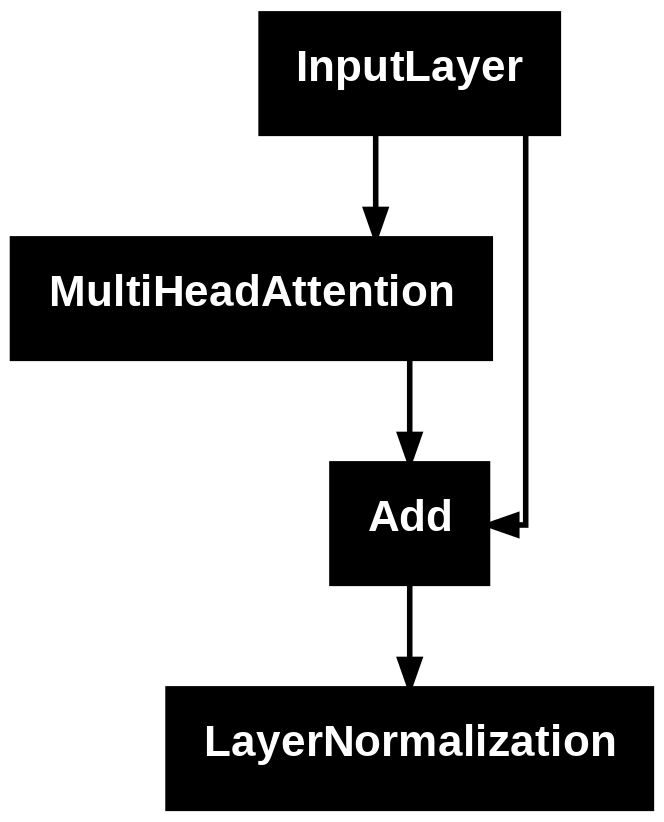

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
def cross_attention(input_shape, context_shape, prefix = 'att', **kwargs):
  context = tf.keras.layers.Input(shape = context_shape, dtype = 'float32', name = f"{prefix}_ctx2")
  inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f"{prefix}_in2")
  attention = tf.keras.layers.MultiHeadAttention(name = f"{prefix}_att2", **kwargs)
  norm = tf.keras.layers.LayerNormalization(name = f"{prefix}_norm2")
  add = tf.keras.layers.Add(name = f"{prefix}_ad2")

  attout = attention(query = inputs, value = context, key = context)
  output = norm(add([inputs, attout]))

  model = tf.keras.Model(inputs = [(context, inputs)], outputs = output, name = f"{prefix}_crs_at")

  return model

In [ ]:
model = cross_attention(input_shape = (seq_length, key_dim), context_shape = (seq_length, key_dim), num_heads = num_heads, key_dim = key_dim)

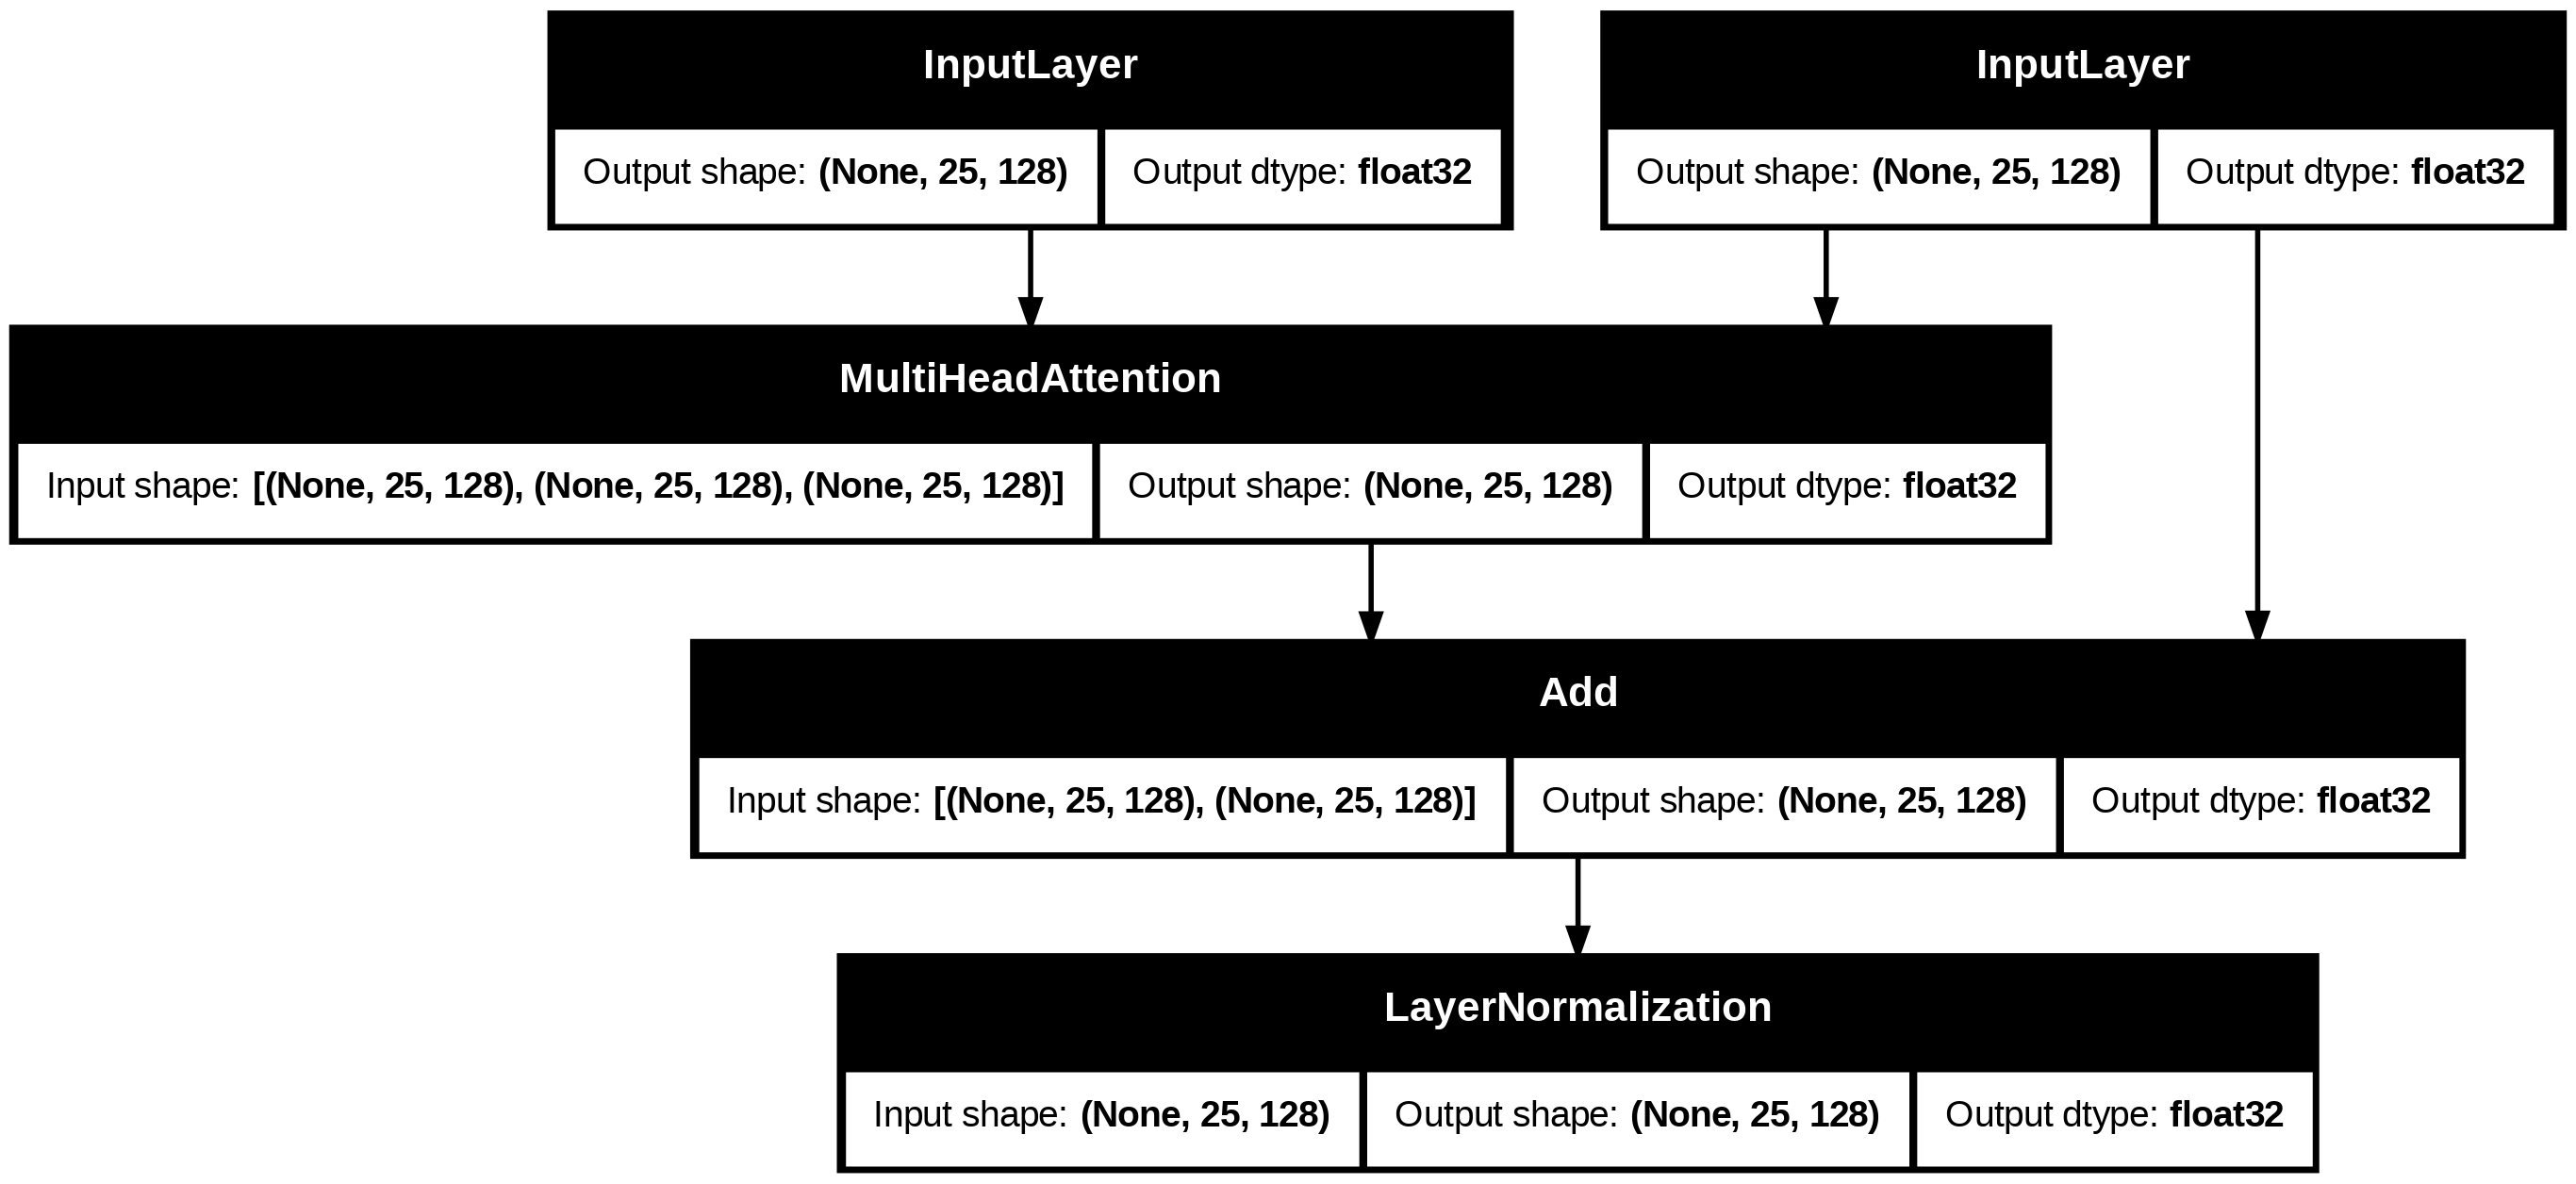

In [ ]:
tf.keras.utils.plot_model(model, show_shapes= True, show_dtype= True, show_layer_activations=True)

#feed forward

In [ ]:
def feed_forward(input_shape, model_dim, ff_dim, dropout = 0.1, prefix = 'ff'):
  inputs = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in3')
  dense1 = tf.keras.layers.Dense(ff_dim, activation = 'relu', name = f'{prefix}_ff1')
  dense2 = tf.keras.layers.Dense(model_dim, name = f'{prefix}_ff2')
  dropout_layer = tf.keras.layers.Dropout(dropout, name = f'{prefix}_drop')

  add = tf.keras.layers.Add(name = f'{prefix}_add3')

  ffout = dropout_layer(dense2(dense1(inputs)))

  norm = tf.keras.layers.LayerNormalization(name = f'{prefix}_norm3')
  output = norm(add([inputs, ffout]))

  model = tf.keras.Model(inputs = inputs, outputs = output, name = f'{prefix}_ff')

  return model

In [ ]:
ff_dim = 512

model = feed_forward(input_shape = (seq_length, key_dim), model_dim = key_dim, ff_dim = ff_dim)

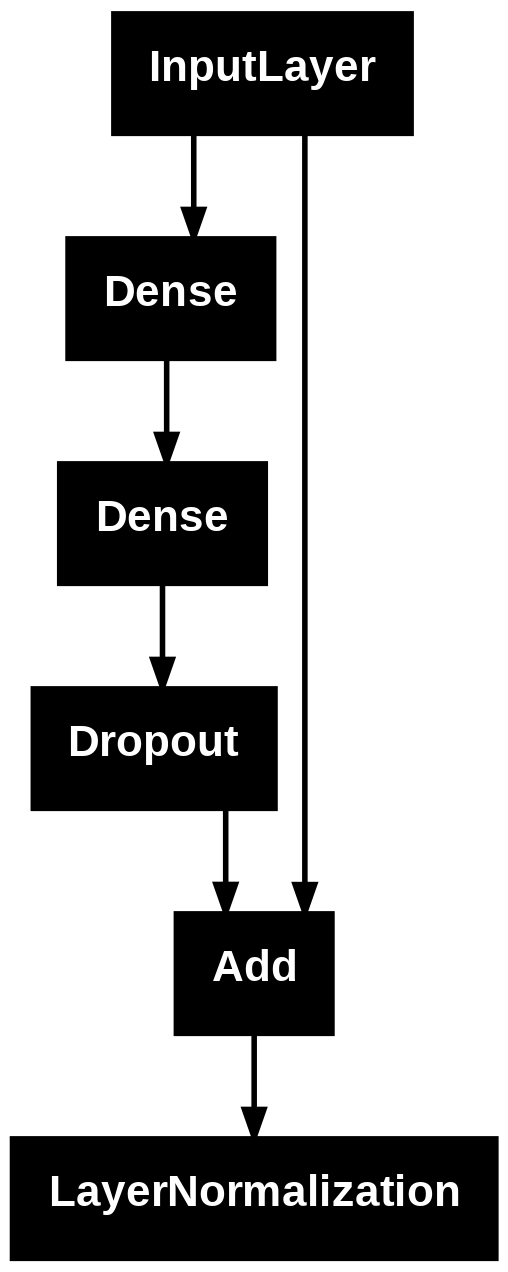

In [ ]:
tf.keras.utils.plot_model(model)

#Encoder and Decoder

In [ ]:
import tensorflow as tf

def encoder(input_shape, key_dim, ff_dim, dropout = 0.1, prefix = 'enc', **kwargs):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in0'),
      self_attention(input_shape, prefix = prefix, key_dim = key_dim, mask=False, **kwargs),
      feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
  ])

  return model

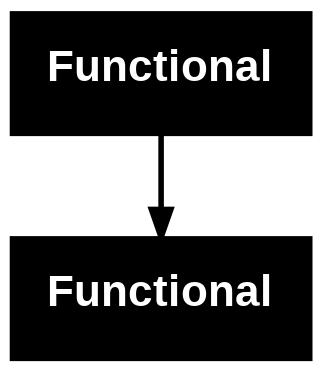

In [ ]:
seq_length = 25
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape = (seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, num_heads=num_heads)


tf.keras.utils.plot_model(model)

In [ ]:
def decoder(input_shape, key_dim, ff_dim, dropout = 0.1, prefix = 'dec', **kwargs):
  input = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_in0')
  content = tf.keras.layers.Input(shape = input_shape, dtype = 'float32', name = f'{prefix}_ctx0')
  attmodel = self_attention(input_shape, prefix = prefix, key_dim = key_dim, mask=True, **kwargs)
  crossmodel = cross_attention(input_shape, context_shape=input_shape, prefix = prefix, key_dim = key_dim, **kwargs)
  ff_model = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)


  x = attmodel(input)
  x = crossmodel([(content, x)])
  output = ff_model(x)

  model = tf.keras.Model(inputs = [input, content], outputs = output, name = prefix)

  return model

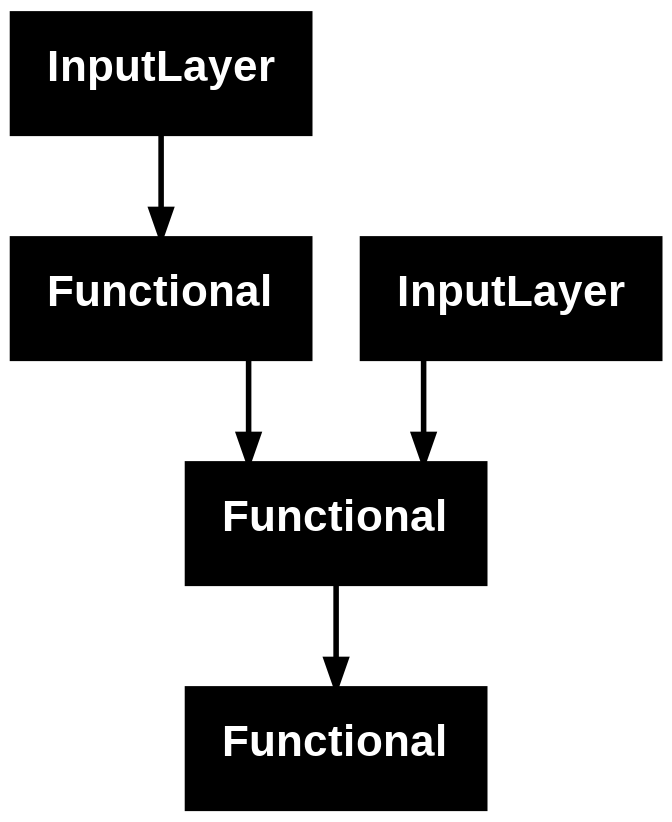

In [ ]:
seq_length = 25
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape = (seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim, num_heads=num_heads)


tf.keras.utils.plot_model(model)

In [ ]:
def transformer(num_layers, num_heads, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout = 0.1, name = 'transformer'):
  input_enc = tf.keras.layers.Input(shape = (seq_length,), dtype='float32', name = 'enc_input')
  input_dec = tf.keras.layers.Input(shape = (seq_length,), dtype='float32', name = 'dec_input')

  emb_enc = PositionalEmbedding(seq_length, vocab_size_en, key_dim, name = 'embed_enc')
  emb_dec = PositionalEmbedding(seq_length, vocab_size_fr, key_dim, name = 'embed_dec')

  encoders = [encoder(input_shape = (seq_length, key_dim), key_dim = key_dim, ff_dim = ff_dim, dropout = dropout, prefix=f"enc{i}", num_heads = num_heads) for i in range(num_layers)]
  decoders = [decoder(input_shape = (seq_length, key_dim), key_dim = key_dim, ff_dim = ff_dim, dropout = dropout, prefix=f"dec{i}", num_heads = num_heads) for i in range(num_layers)]


  final = tf.keras.layers.Dense(vocab_size_fr, name = 'linear')

  x1 = emb_enc(input_enc)
  x2 = emb_dec(input_dec)

  for layer in encoders:
    x1 = layer(x1)

  for layer in decoders:
    x2 = layer([x2, x1])

  output = final(x2)


  try:
    del output._keras_mask
  except AttributeError:
    pass


  model = tf.keras.Model(inputs = [input_enc, input_dec], outputs = output, name = name)

  return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'sequential_10' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'dec0' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


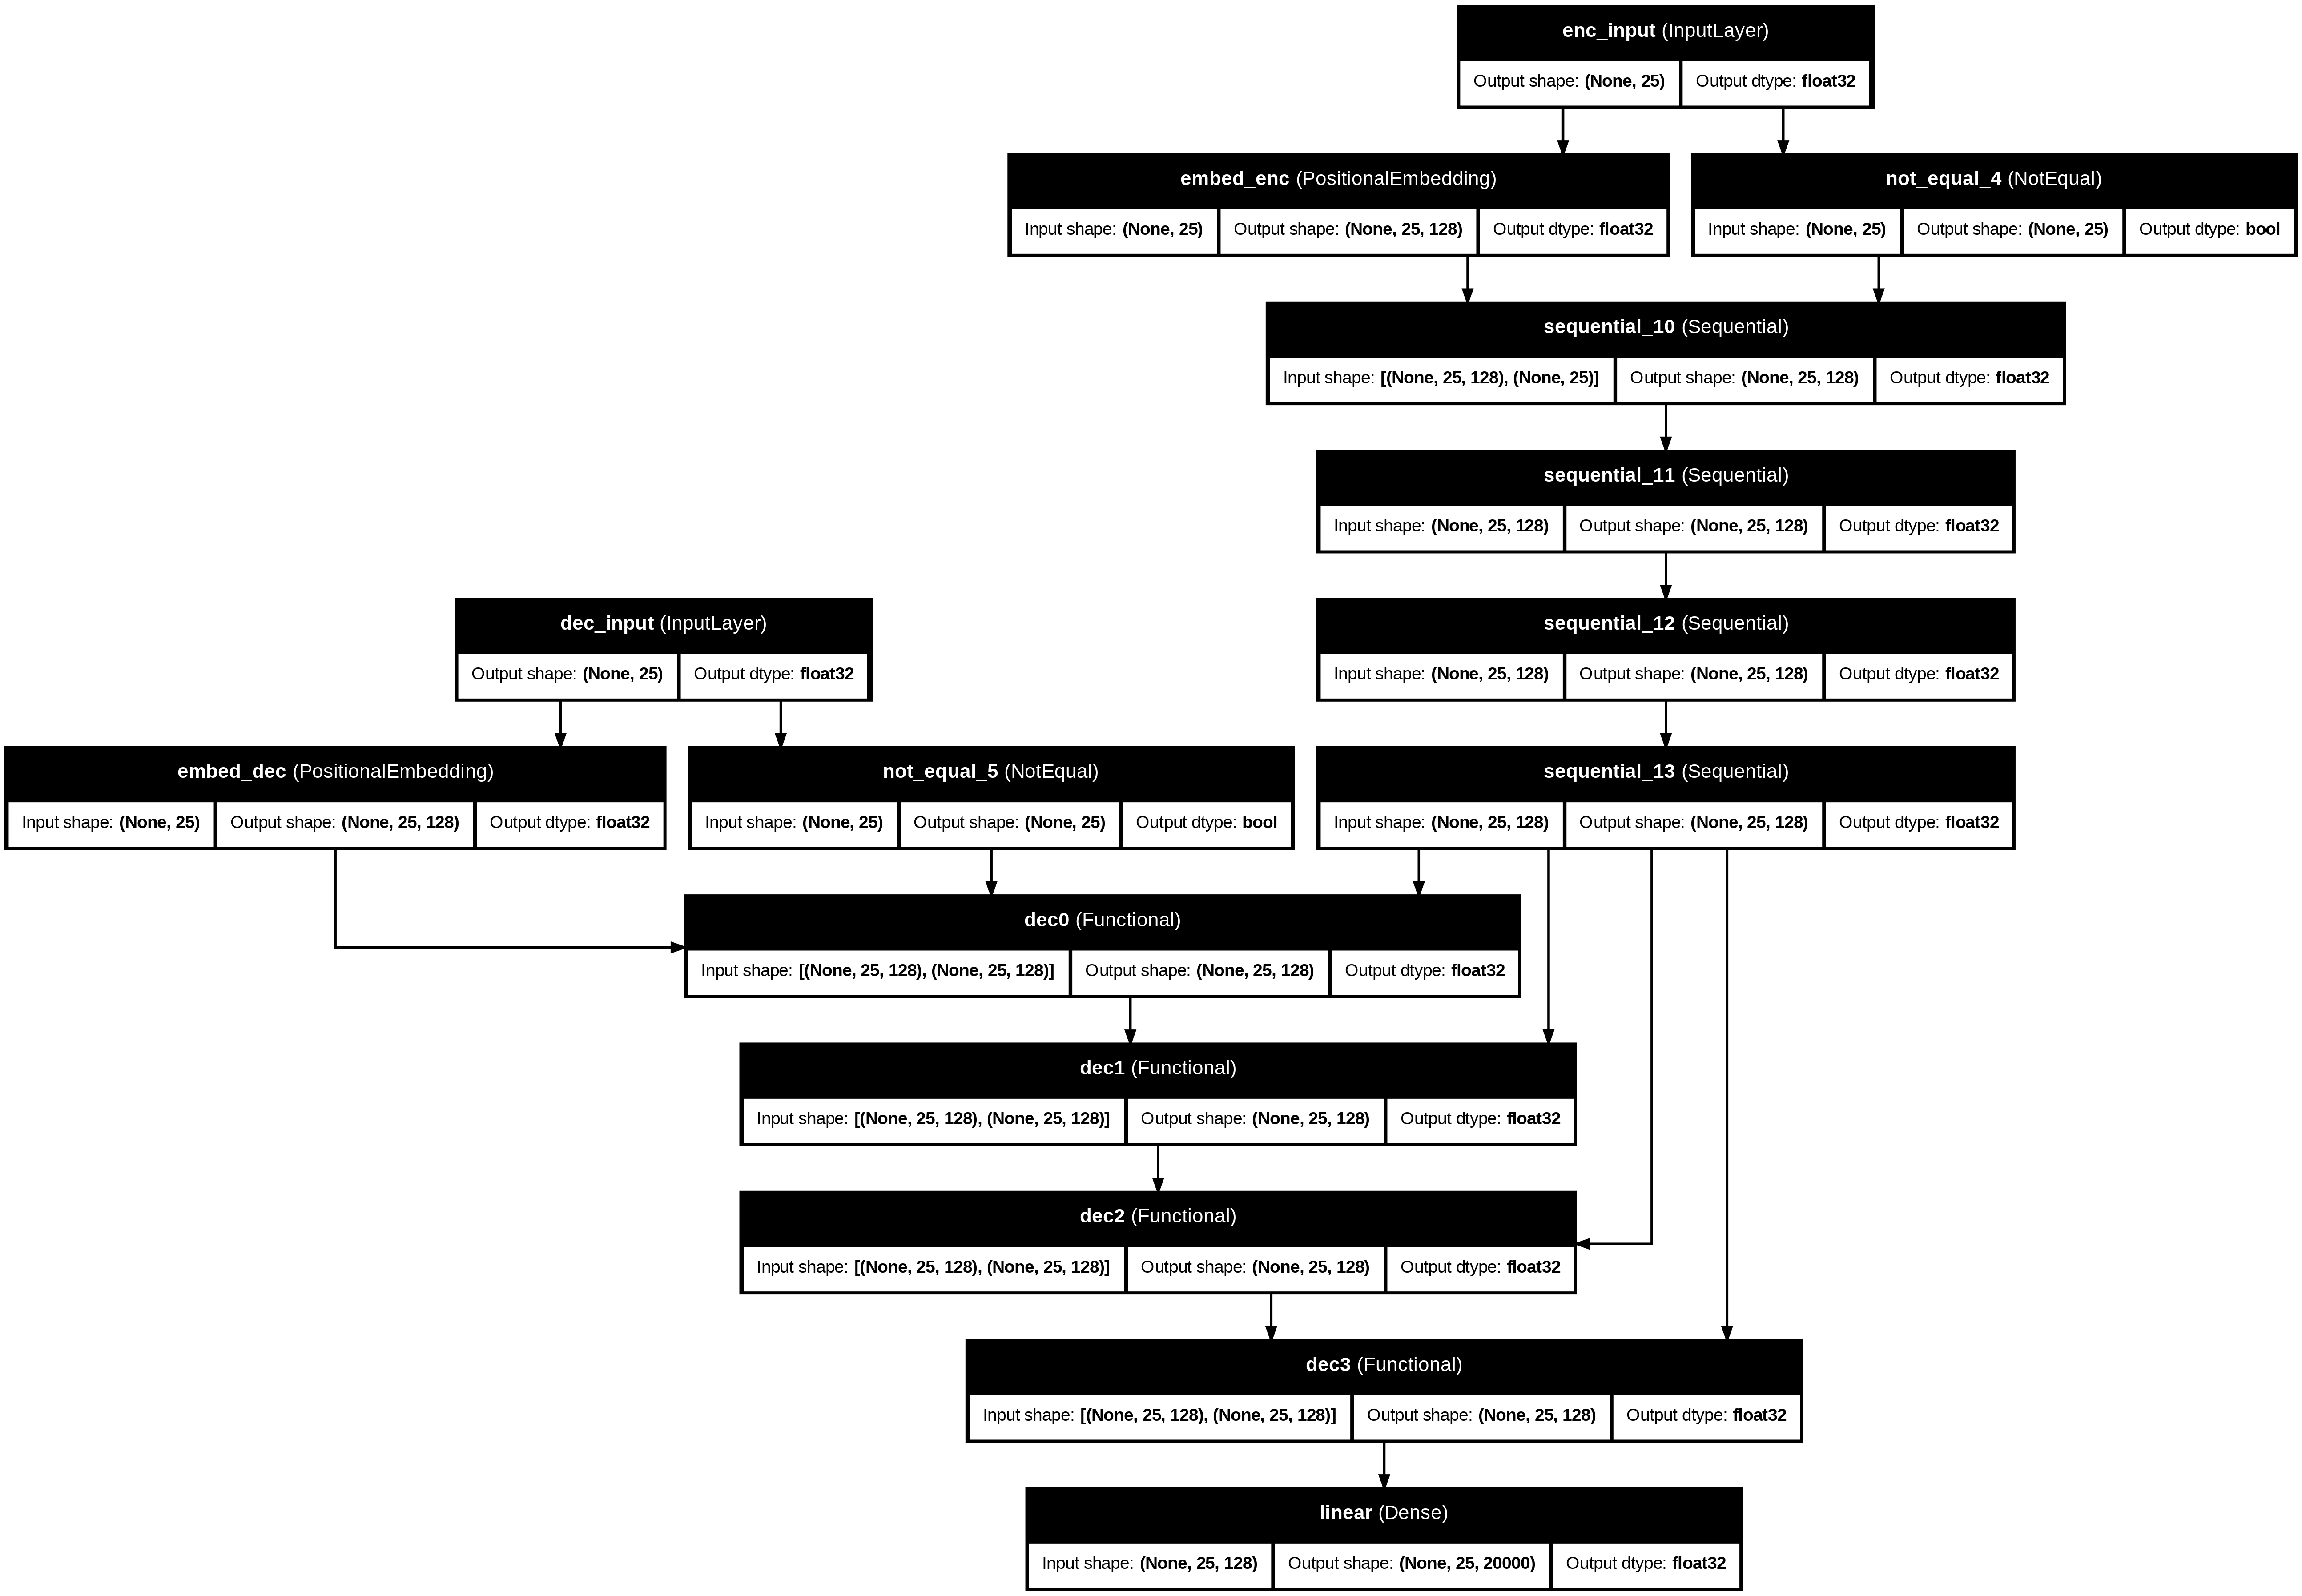

In [ ]:
seq_length = 25
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000

model = transformer(num_layers, num_heads, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout)

tf.keras.utils.plot_model(model, show_shapes=True, show_dtype= True, show_layer_names = True)

#Improve GPT Model

In [ ]:
class customSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, key_dim, warmup_steps = 4000):
    super().__init__()
    self.key_dim = key_dim
    self.warmup_steps = warmup_steps


    self.d = tf.cast(self.key_dim, tf.float32)


  def __call__(self, step):
    step = tf.cast(step, dtype = tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps** -1.5)

    return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)


  def get_config(self):
    config = {
        "key_dim" : self.key_dim,
        "warmup_steps" : self.warmup_steps
        }

    return config


key_dim = 128
lr = customSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1 = 0.9, beta_2 = 0.98, epsilon = 1e-9)

In [ ]:
def masked_loss(label, pred):
  mask = label != 0

  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
      )
  loss = loss_object(label, pred)


  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred


  mask = label != 0
  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)

  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(loss = masked_loss, optimizer= optimizer, metrics = [masked_accuracy])
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ enc_input           │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_enc           │ (None, 25, 128)   │  1,280,000 │ enc_input[0][0]   │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 25)        │          0 │ enc_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 25, 128)   │    659,712 │ embed_enc[0][0],  │
│ (Sequential)        │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 25, 128)   │    659,712 │ sequential_10[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_input           │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 25, 128)   │    659,712 │ sequential_11[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed_dec           │ (None, 25, 128)   │  2,560,000 │ dec_input[0][0]   │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 25, 128)   │    659,712 │ sequential_12[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 25)        │          0 │ dec_input[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec0 (Functional)   │ (None, 25, 128)   │  1,187,456 │ embed_dec[0][0],  │
│                     │                   │            │ sequential_13[0]… │
│                     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec1 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec0[0][0],       │
│                     │                   │            │ sequential_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec2 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec1[0][0],       │
│                     │                   │            │ sequential_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec3 (Functional)   │ (None, 25, 128)   │  1,187,456 │ dec2[0][0],       │
│                     │                   │            │ sequential_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear (Dense)      │ (None, 25, 20000) │  2,580,000 │ dec3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,808,672 (52.68 MB)

 Trainable params: 13,808,672 (52.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, epochs= 20, validation_data = test_ds)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'enc0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'sequential_10' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'dec0_att' (of type Functional) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.12/dis

1828/1828 ━━━━━━━━━━━━━━━━━━━━ 206s 90ms/step - loss: 7.4169 - masked_accuracy: 0.1465 - val_loss: 4.3234 - val_masked_accuracy: 0.3047
Epoch 2/20
  57/1828 ━━━━━━━━━━━━━━━━━━━━ 2:28 84ms/step - loss: 4.4733 - masked_accuracy: 0.3074

KeyboardInterrupt: 

#Model Testing

NameError: name 'history' is not defined

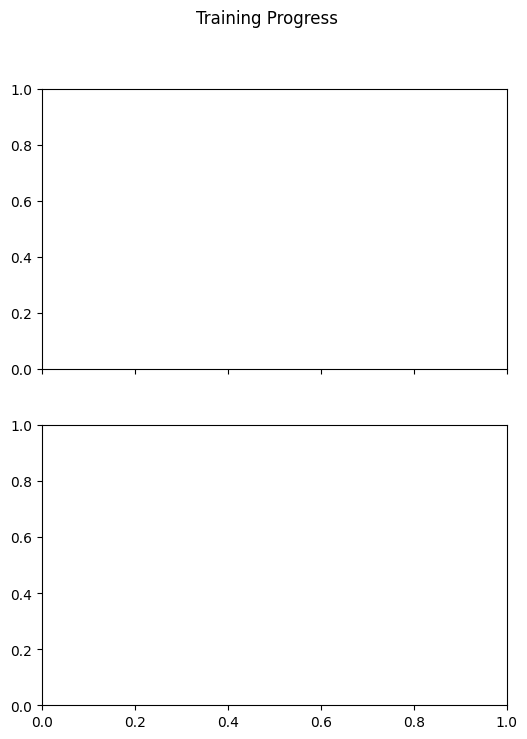

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize = (6, 8), sharex = True)


fig.suptitle("Training Progress")

x = list(range(1,21))
axes[0].plot(x, history.history['loss'], alpha = 0.5, label = 'loss' )
axes[0].plot(x, history.history['val_loss'], alpha = 0.5, label = 'val_loss' )
axes[0].set_ylabel('Loss')
axes[0].legend(loc = 'upper right')

axes[1].plot(x, history.history['masked_accuracy'], alpha = 0.5, label = 'masked_accuracy' )
axes[1].plot(x, history.history['val_masked_accuracy'], alpha = 0.5, label = 'val_masked_accuracy' )
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

plt.show()

#Check the model

In [ ]:
def translate(sentence):

  enc_tokens = eng_vect(['This is a test.'])
  lookup = list(fre_vect.get_vocabulary())
  start_sent, end_sent = "[start]", "[end]"
  output_sent = [start_sent]

  for i in range(seq_length):
    vector = fre_vect([''.join(output_sent)])
    assert vector.shape == (1, seq_length + 1)
    dec_tokens = vector[:, :-1]
    assert dec_tokens.shape == (1, seq_length)
    pred = model.predict([enc_tokens, dec_tokens])
    assert pred.shape == (1, seq_length, vocab_size_fr)
    word = lookup[tf.argmax(pred[0, i,:])]
    output_sent.append(word)

    if word == end_sent:
      break

  return output_sent

In [ ]:
seq_length = 25
vocab_size_en = 10000
vocab_size_fr = 20000
test_count = 20

for n in range(test_count):
  eng_sent, fre_sent = random.choice(text_pair)

  trans = translate(eng_sent)


  print(f"Test case : {n}")
  print(f"English : {eng_sent}")
  print(f"Translated Value: {''.join(trans)}")
  print(f"French : {fre_sent}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Test case : 0
English : tom didn't do that very much.
Translated Value: [start]leest!!![end]
French : [start] tom ne le faisait pas beaucoup. [end]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Test case : 1
English : you should really tell tom not to do that.
Translated Value: [start]leest!!![end]
French : [start] tu devrais vraiment dire à tom de ne pas le faire. [end]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0